<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-данных" data-toc-modified-id="Описание-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание данных</a></span></li><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Таблица-contract:" data-toc-modified-id="Таблица-contract:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Таблица contract:</a></span></li><li><span><a href="#Таблица-personal:" data-toc-modified-id="Таблица-personal:-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Таблица personal:</a></span></li><li><span><a href="#Таблица-internet:" data-toc-modified-id="Таблица-internet:-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Таблица internet:</a></span></li><li><span><a href="#Таблица-phone:" data-toc-modified-id="Таблица-phone:-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Таблица phone:</a></span></li><li><span><a href="#Объединение-таблиц:" data-toc-modified-id="Объединение-таблиц:-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Объединение таблиц:</a></span></li></ul></li><li><span><a href="#Исследование-данных" data-toc-modified-id="Исследование-данных-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Исследование данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Логистическая-регессия" data-toc-modified-id="Логистическая-регессия-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Логистическая регессия</a></span></li><li><span><a href="#LightGBM-для-регрессии" data-toc-modified-id="LightGBM-для-регрессии-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>LightGBM для регрессии</a></span></li><li><span><a href="#Градиентный-бустинг-catboost" data-toc-modified-id="Градиентный-бустинг-catboost-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Градиентный бустинг catboost</a></span></li></ul></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Предсказание ухода клиента
Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.



## Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

Импортируем необходимые бибилиотеки:

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import seaborn as sns

from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter('ignore')
from IPython.display import display 

## Обзор данных

In [2]:
df_contract = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [4]:
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')

In [5]:
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')

Посмотрим на первые десять строк таблиц:

In [6]:
df_contract.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
df_phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [8]:
df_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [9]:
df_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Каждый объект в таблице — это информация о поведении одного пользователя. В таблицах совпадают значения из поля `customerID` - это уникальный номер клиента.

Для таблиц

`contract`:
- BeginDate — дата начала договора,
- EndDate — дата прекращения договора,
- Type — тип договора (с помесячной оплатой, годовой или двухгодовой),
- PaperlessBilling — есть ли электронный счет,
- PaymentMethod — метод оплаты,
- MonthlyCharges — ежемесячная плата за услуги,
- TotalCharges — общая плата за услуги за все время,

`personal`:
- gender — пол клиента,
- SeniorCitizen — является ли клиент пенсионером,
- Partner — наличие супруга у клиента,
- Dependents — наличие иждивенцев у клиента,

`internet`:
- InternetService — тип подключения интернета (DSL, оптоволокно),
- OnlineSecurity — наличие услуги блокировки небезопасных сайтов,
- OnlineBackup — наличие облачного хранилища для создания резервных копий,
- DeviceProtection — наличие услуги антивируса,
- TechSupport — наличие выделенной линии технической поддержки,
- StreamingTV — наличие услуги онлайн-телевидения,
- StreamingMovies — наличие услуги онлайн-кинотеатра,

`phone`:
- MultipleLines — наличие нескольких телефонных линий у клиента.

## Предобработка данных

Посмотрим поподробнее на данные из каждой таблицы, нет ли пропусков, дубликатов, неадекватных данных...

Далее объединим таблицы.

### Таблица contract:

Информация о договорах актуальна на 1 февраля 2020.

In [10]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Пропусков в таблице нет. Необходимо привести названия столбцов в соответствии с хорошим стилем, и также поменять типы данных некоторых столбцов.

Наш целевой признак это ушел клиент или остался: столбец `EndDate`. Поменяем в нём данные на 0 если клиент остался (значение No) и на 1 если ушел (есть дата разрыва контракта).

In [11]:
df_contract.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [12]:
df_contract = df_contract.rename(columns={"customerID": "customer_id",
                            "BeginDate": "begin_date",
                            "EndDate": "end_date",
                            "Type": "type",
                            "PaperlessBilling": "paper_less_billing",
                            "PaymentMethod": "payment_method",
                            "MonthlyCharges": "monthly_charges",
                            "TotalCharges": "total_charges",
                            })

Создадим признак года начала пользования услугами.

In [13]:
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format='%Y-%m-%d')
df_contract['begin_year'] = pd.DatetimeIndex(df_contract['begin_date']).year

In [14]:
df_contract['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Введём новый столбец с длительностью контракта для каждого клиента. Для клиентов, которые не разорвали контракт и в атрибуте `end_date` у них стоит No - укажем дату выгрузки данных.

In [15]:
df_contract['duration'] = df_contract['end_date']

In [16]:
df_contract['end_date'] = df_contract['end_date'].apply(lambda x: 0 if x == 'No' else 1)

In [17]:
df_contract['end_date'].value_counts()

0    5174
1    1869
Name: end_date, dtype: int64

In [18]:
1869/(1869+5174)*100

26.536987079369588

26.5% всех представленных клиентов покинули провайдера. Клиенты уходили с октября 2019 года по январь 2020 года.

In [19]:
df_contract['duration'] = df_contract['duration'].apply(lambda x: '2020-02-01' if x == 'No' else x)

In [20]:
df_contract['duration'] = pd.to_datetime(df_contract['duration'],format='%Y.%m.%d')

In [21]:
df_contract['duration'].value_counts()

2020-02-01    5174
2019-11-01     485
2019-12-01     466
2020-01-01     460
2019-10-01     458
Name: duration, dtype: int64

In [22]:
df_contract['duration'] = (pd.DatetimeIndex(
    df_contract['duration']).year - pd.DatetimeIndex(
    df_contract['begin_date']).year)* 12 + pd.DatetimeIndex(
    df_contract['duration']).month - pd.DatetimeIndex(
    df_contract['begin_date']).month

Чтобы перевести столбец `total_charges` в тип данных float, необходимо заполнить пустые значения. Создадим столбец с флагами, если в интересующем нас столбце нет значения и посмотрим на получившиеся данные:

In [23]:
def isfloat(value): 
    try:
        float(value)
        return True
    except ValueError:
        return False

In [24]:
df_contract['condition'] = df_contract['total_charges'].apply(isfloat)

In [25]:
df_contract[df_contract['condition']==False]

,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,begin_year,duration,condition
488,4472-LVYGI,2020-02-01,0,Two year,Yes,Bank transfer (automatic),52.55,,2020,0,False
753,3115-CZMZD,2020-02-01,0,Two year,No,Mailed check,20.25,,2020,0,False
936,5709-LVOEQ,2020-02-01,0,Two year,No,Mailed check,80.85,,2020,0,False
1082,4367-NUYAO,2020-02-01,0,Two year,No,Mailed check,25.75,,2020,0,False
1340,1371-DWPAZ,2020-02-01,0,Two year,No,Credit card (automatic),56.05,,2020,0,False
3331,7644-OMVMY,2020-02-01,0,Two year,No,Mailed check,19.85,,2020,0,False
3826,3213-VVOLG,2020-02-01,0,Two year,No,Mailed check,25.35,,2020,0,False
4380,2520-SGTTA,2020-02-01,0,Two year,No,Mailed check,20.00,,2020,0,False
5218,2923-ARZLG,2020-02-01,0,One year,Yes,Mailed check,19.70,,2020,0,False
6670,4075-WKNIU,2020-02-01,0,Two year,No,Mailed check,73.35,,2020,0,False


Общий платеж можно вычислить исходя из ежемесячного платежжа и типа оплаты. Во всех строках кроме 5218 оплата происходила за два года (24 месяца), а у этой строки за год (12 месяцев). Умножим ежемесячный плтеж на количество месяцев:

In [26]:
df_contract.loc[df_contract['condition']==False,'total_charges'] = df_contract.loc[df_contract['condition']==False,'monthly_charges']*24
df_contract.loc[5218,'total_charges'] = df_contract.loc[5218,'monthly_charges']*12
df_contract = df_contract.drop('condition',axis=1)

In [27]:
df_contract['total_charges'] = df_contract['total_charges'].astype('float')

Построим распределение количества клиентов по ежемесячному платежу, общему платежу.

<AxesSubplot:>

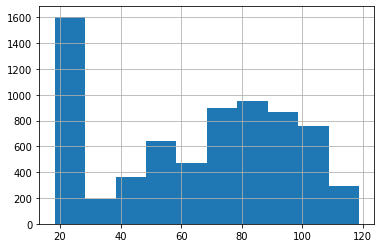

In [28]:
df_contract['monthly_charges'].hist()

<AxesSubplot:>

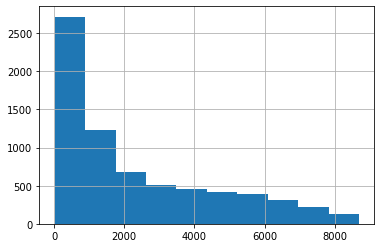

In [29]:
df_contract['total_charges'].hist()

Ежемесячные платежи лежат в рамках от 19 до 120, а вот общие платежи располагаются очень близко к нулю. Проверим минимальное значеие таких платежей.

In [30]:
df_contract['total_charges'].min()

18.8

Значения в столбцах оплаты выглядят адекватно. Нет значений равных нулю или экстремально высоких значений. Значения общей оплаты могут быть равны одному ежемесячному платежу, но нулевых значения в данных нет.

Приведём значения столбцов `type`, `paper_less_billing` и `payment_method` к нижнему регистру и проверим данные на наличие явных дубликатов.

In [31]:
cols = ['type','paper_less_billing','payment_method']
for i in cols:
    df_contract[i] = df_contract[i].str.lower()

Также посмотрим какие значения есть у данных атрибутов:

In [32]:
df_contract['type'].value_counts()

month-to-month    3875
two year          1695
one year          1473
Name: type, dtype: int64

In [33]:
df_contract['paper_less_billing'].value_counts()

yes    4171
no     2872
Name: paper_less_billing, dtype: int64

In [34]:
df_contract['payment_method'].value_counts()

electronic check             2365
mailed check                 1612
bank transfer (automatic)    1544
credit card (automatic)      1522
Name: payment_method, dtype: int64

In [35]:
df_contract.duplicated().sum()

0

In [36]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         7043 non-null   object        
 1   begin_date          7043 non-null   datetime64[ns]
 2   end_date            7043 non-null   int64         
 3   type                7043 non-null   object        
 4   paper_less_billing  7043 non-null   object        
 5   payment_method      7043 non-null   object        
 6   monthly_charges     7043 non-null   float64       
 7   total_charges       7043 non-null   float64       
 8   begin_year          7043 non-null   int64         
 9   duration            7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(4)
memory usage: 550.4+ KB


Явных дубликатов нет. Атрибуты переименованы согласно хорошему стилю. Пропусков нет. Данные выглядят адекватно.

### Таблица personal:

In [37]:
df_personal.head(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Переименуем столбцы согласно хорошему стилю. Значения атрибута пола приведём к нижнему регистру. Атрибуты наличия партнёра и иждивенцев переведём в бинарный формат.

In [38]:
df_personal = df_personal.rename(columns={
                            "customerID": "customer_id",
                            "gender": "gender",
                            "SeniorCitizen": "senior_citizen",
                            "Partner": "partner",
                            "Dependents": "dependents"
                            })

In [39]:
df_personal['gender'] = df_personal['gender'].str.lower()

In [40]:
df_personal['partner'] = df_personal['partner'].apply(lambda x: 1 if x == 'Yes' else 0)

In [41]:
df_personal['dependents'] = df_personal['dependents'].apply(lambda x: 1 if x == 'Yes' else 0)

Проверим, какие значения встречаются в атрибуте пола. Проверим наличие явных дубликатов.

In [42]:
df_personal['gender'].value_counts()

male      3555
female    3488
Name: gender, dtype: int64

In [43]:
df_personal.duplicated().sum()

0

Явных дубликатов нет. Атрибуты переименованы согласно хорошему стилю. Пропусков нет. Данные выглядят адекватно.

### Таблица internet:

In [44]:
df_internet.head(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Переименуем столбцы согласно хорошему стилю. Значения атрибутов формата Да/Нет  переведём в бинарный формат.

In [45]:
df_internet = df_internet.rename(columns={
                            "customerID": "customer_id",
                            "InternetService": "internet_service",
                            "OnlineSecurity": "online_security",
                            "OnlineBackup": "online_backup",
                            "DeviceProtection": "device_protection",
                            "TechSupport": "tech_support",
                            "StreamingTV": "streaming_tv",
                            "StreamingMovies": "streaming_movies"
                            })

In [46]:
cols = ['online_security','online_backup','device_protection','tech_support','streaming_tv','streaming_movies']
for i in cols:
    df_internet[i] = df_internet[i].apply(lambda x: 1 if x == 'Yes' else 0)

Посмотрим, много ли клиентов пользуются дополнительными услугами:

In [47]:
for i in cols:
    print(i, ":")
    print(df_internet[i].value_counts())

online_security :
0    3498
1    2019
Name: online_security, dtype: int64
online_backup :
0    3088
1    2429
Name: online_backup, dtype: int64
device_protection :
0    3095
1    2422
Name: device_protection, dtype: int64
tech_support :
0    3473
1    2044
Name: tech_support, dtype: int64
streaming_tv :
0    2810
1    2707
Name: streaming_tv, dtype: int64
streaming_movies :
0    2785
1    2732
Name: streaming_movies, dtype: int64


Проверим наличие явных дубликатов:

In [48]:
df_internet.duplicated().sum()

0

Явных дубликатов нет. Атрибуты переименованы согласно хорошему стилю. Пропусков нет. Данные выглядят адекватно.

### Таблица phone:

In [49]:
df_phone.head(5)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Переименуем столбцы согласно хорошему стилю. Атрибут наличия мультилинии переведём в бинарный формат.

In [50]:
df_phone = df_phone.rename(columns={
                            "customerID": "customer_id",
                            "MultipleLines": "multiple_lines"
                            })

In [51]:
df_phone['multiple_lines'].value_counts()

No     3390
Yes    2971
Name: multiple_lines, dtype: int64

In [52]:
df_phone.duplicated().sum()

0

Явных дубликатов нет. Атрибуты переименованы согласно хорошему стилю. Пропусков нет. Данные выглядят адекватно.

### Объединение таблиц:

В таблицах есть код клиента `customer_id`, объединим по нему  все таблицы. 

In [53]:
result = pd.merge(df_contract, df_personal, how="outer", on=["customer_id", "customer_id"])
result = pd.merge(result, df_internet, how="outer", on=["customer_id", "customer_id"])
result = pd.merge(result, df_phone, how="outer", on=["customer_id", "customer_id"])

In [54]:
result.head(5)

,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,begin_year,duration,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,0,month-to-month,yes,electronic check,29.85,29.85,2020,1,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,NaN
1,5575-GNVDE,2017-04-01,0,one year,no,mailed check,56.95,1889.50,2017,34,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,No
2,3668-QPYBK,2019-10-01,1,month-to-month,yes,mailed check,53.85,108.15,2019,2,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,No
3,7795-CFOCW,2016-05-01,0,one year,no,bank transfer (automatic),42.30,1840.75,2016,45,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,NaN
4,9237-HQITU,2019-09-01,1,month-to-month,yes,electronic check,70.70,151.65,2019,2,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,No


In [55]:
result.isna().sum()

customer_id              0
begin_date               0
end_date                 0
type                     0
paper_less_billing       0
payment_method           0
monthly_charges          0
total_charges            0
begin_year               0
duration                 0
gender                   0
senior_citizen           0
partner                  0
dependents               0
internet_service      1526
online_security       1526
online_backup         1526
device_protection     1526
tech_support          1526
streaming_tv          1526
streaming_movies      1526
multiple_lines         682
dtype: int64

В таблице появились пустые значения. 

Таблица о телефонной линни содержит информацию только о клиентах, которые пользуюутся телефоном (с одним или несколькими каналами). При объединении данных у пользователей, которые не пользуются телефонной линией, появились пропуски. Аналогично с клиентами, которые не пользуются интернетом. Заполним такие пропуски значениями 'no_phone' и 'no_internet'. У клиентов, которые не пользуются интернетом все остальные атрибуты данной таблицы заменим на нули.

In [56]:
result['internet_service'] = result['internet_service'].fillna('no_internet')

In [57]:
result['multiple_lines'] = result['multiple_lines'].fillna('no_phone')

In [58]:
result = result.fillna(0)

In [59]:
result.head(5)

,customer_id,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,begin_year,duration,...,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,2020-01-01,0,month-to-month,yes,electronic check,29.85,29.85,2020,1,...,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,no_phone
1,5575-GNVDE,2017-04-01,0,one year,no,mailed check,56.95,1889.50,2017,34,...,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,No
2,3668-QPYBK,2019-10-01,1,month-to-month,yes,mailed check,53.85,108.15,2019,2,...,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,No
3,7795-CFOCW,2016-05-01,0,one year,no,bank transfer (automatic),42.30,1840.75,2016,45,...,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,no_phone
4,9237-HQITU,2019-09-01,1,month-to-month,yes,electronic check,70.70,151.65,2019,2,...,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,No


Пропусков в данных нет, предобработка данных закончена. Переходим к исследованию данных.

## Исследование данных

Взглянем на гистограмму ушедших клиентов по году их подключения:

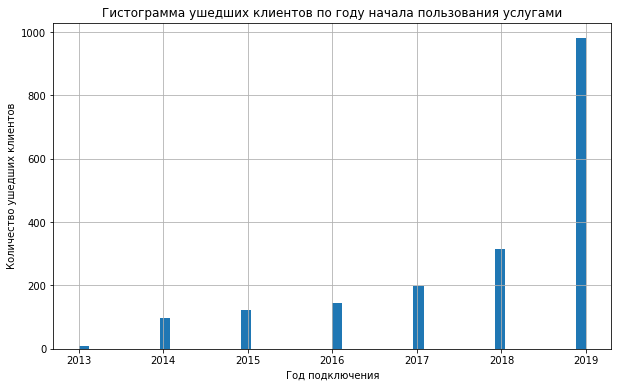

In [60]:
plt.figure(figsize=(10,6))
df_contract.query('end_date == 1')['begin_year'].plot(kind='hist', bins=50, grid=True)
plt.title('Гистограмма ушедших клиентов по году начала пользования услугами')
plt.xlabel('Год подключения')
plt.ylabel('Количество ушедших клиентов')
plt.show()

В основном уходят новые клиенты, подключившиеся в 2019 году. Старые же клиенты уходят значительно реже. Клиенты уходили с октября 2019 года по январь 2020 года.

In [61]:
contract_grouped = df_contract.groupby(by=['type', 'begin_year']).sum()
contract_grouped.drop([ 'monthly_charges', 'total_charges'], axis=1)

end_date  duration
type           begin_year                    
month-to-month 2014              29      6673
               2015              71     12627
               2016             108     13391
               2017             178     14943
               2018             296     13314
               2019             973      8720
               2020               0       224
one year       2013               1        72
               2014              45     19461
               2015              40     17950
               2016              34     11556
               2017              19      7797
               2018              19      4008
               2019               8      1081
               2020               0         7
two year       2013               7       497
               2014              24     65750
               2015              12     16395
               2016               3      7960
               2017               2      3200
               2018               0      1767
               2019               0       595
               2020               0         2

Клиенты с ежемесячным платежом уходят значительно чаще тех, у кого годовая и двухгодовая оплата.

Посмотрим на корреляцию признаков в таблице контрактов у ушедших клиентов и у оставшихся:

array([[<AxesSubplot:xlabel='end_date', ylabel='end_date'>,
        <AxesSubplot:xlabel='monthly_charges', ylabel='end_date'>,
        <AxesSubplot:xlabel='total_charges', ylabel='end_date'>,
        <AxesSubplot:xlabel='begin_year', ylabel='end_date'>,
        <AxesSubplot:xlabel='duration', ylabel='end_date'>],
       [<AxesSubplot:xlabel='end_date', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='monthly_charges', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='total_charges', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='begin_year', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='duration', ylabel='monthly_charges'>],
       [<AxesSubplot:xlabel='end_date', ylabel='total_charges'>,
        <AxesSubplot:xlabel='monthly_charges', ylabel='total_charges'>,
        <AxesSubplot:xlabel='total_charges', ylabel='total_charges'>,
        <AxesSubplot:xlabel='begin_year', ylabel='total_charges'>,
        <AxesSubplot:xlabel='duration', ylabel='total_charges

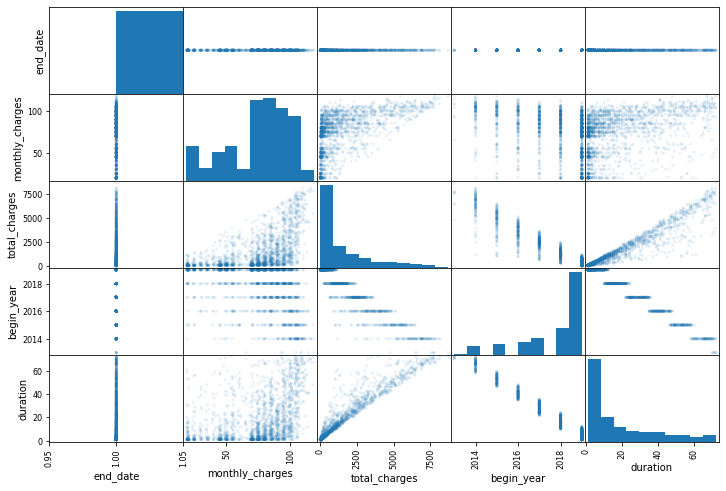

In [62]:
pd.plotting.scatter_matrix(df_contract.query('end_date == 1'), alpha=0.1, figsize=(12,8))

array([[<AxesSubplot:xlabel='end_date', ylabel='end_date'>,
        <AxesSubplot:xlabel='monthly_charges', ylabel='end_date'>,
        <AxesSubplot:xlabel='total_charges', ylabel='end_date'>,
        <AxesSubplot:xlabel='begin_year', ylabel='end_date'>,
        <AxesSubplot:xlabel='duration', ylabel='end_date'>],
       [<AxesSubplot:xlabel='end_date', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='monthly_charges', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='total_charges', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='begin_year', ylabel='monthly_charges'>,
        <AxesSubplot:xlabel='duration', ylabel='monthly_charges'>],
       [<AxesSubplot:xlabel='end_date', ylabel='total_charges'>,
        <AxesSubplot:xlabel='monthly_charges', ylabel='total_charges'>,
        <AxesSubplot:xlabel='total_charges', ylabel='total_charges'>,
        <AxesSubplot:xlabel='begin_year', ylabel='total_charges'>,
        <AxesSubplot:xlabel='duration', ylabel='total_charges

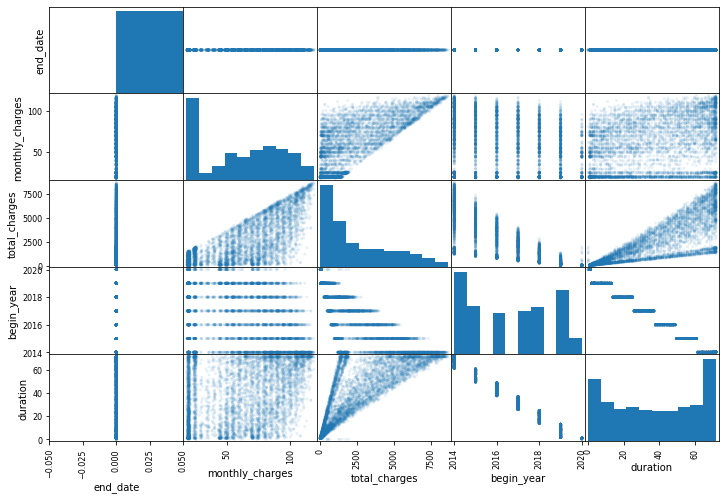

In [63]:
pd.plotting.scatter_matrix(df_contract.query('end_date == 0'), alpha=0.1, figsize=(12,8))

У неушедших клиентов присутствует низкие ежемесячная и общая плата за услуги. Также у ушедших пользователей почти ни у кого нет таких низких ежемесячных платежей. Посмотрим, что это за люди, пользующиеся низким ежемесячным платежом

In [64]:
customer_id_low_pay = df_contract.query('monthly_charges < 40')['customer_id']

In [65]:
result_low_pay = result.loc[result['customer_id'].isin(customer_id_low_pay)].drop([ 'customer_id', 'monthly_charges', 'total_charges', 'begin_year', 'begin_date', 'senior_citizen', 'partner', 'dependents','total_charges'], axis=1)
result_low_pay = result_low_pay.loc[result_low_pay ['end_date'] == 0 ].drop(['end_date'], axis=1)
len(result_low_pay)

1624

In [66]:
list_col = result_low_pay.columns

In [67]:
for col in list_col:
  print(col)
  print(result_low_pay[col].value_counts())
  print()

type
two year          661
month-to-month    565
one year          398
Name: type, dtype: int64

paper_less_billing
no     1123
yes     501
Name: paper_less_billing, dtype: int64

payment_method
mailed check                 749
credit card (automatic)      370
bank transfer (automatic)    348
electronic check             157
Name: payment_method, dtype: int64

duration
1     127
72     67
2      46
3      44
4      42
     ... 
44     12
65     12
30     11
31      9
0       6
Name: duration, Length: 73, dtype: int64

gender
male      834
female    790
Name: gender, dtype: int64

internet_service
no_internet    1413
DSL             211
Name: internet_service, dtype: int64

online_security
0.0    1550
1.0      74
Name: online_security, dtype: int64

online_backup
0.0    1560
1.0      64
Name: online_backup, dtype: int64

device_protection
0.0    1574
1.0      50
Name: device_protection, dtype: int64

tech_support
0.0    1553
1.0      71
Name: tech_support, dtype: int64

streaming_tv
0.0

In [68]:
df_contract['end_date'].value_counts()

0    5174
1    1869
Name: end_date, dtype: int64

In [69]:
1624/(5174)*100

31.387707769617318

31 процент оставшихся клиентов пользуется услугами с очень маленькой абонентской платой: у них в основном одноканальный телефон, но есть и те, у кого DSL интернет и многоканальная линия. Такие клиенты почти не уходили от оператора, в основном уходили те, кому требуется интернет помощнее.

Удалим из получившейся таблицы столбцы начала и конца действия договора, года начала договора. Оставим для модели атрибут "длительность" - сколько времени кллиент пользуется услугами фирмы.

In [70]:
result = result.drop(['begin_date','begin_year'],axis=1)

При моделировании существует проблематика мультиколлинеарности - когда количественные факторы имеют сильную корреляцию друг с другом - больше 0.8.Прверим, есть ли она у нас? Если есть - удалим лишние атрибуты.

In [71]:
result.corr()

,end_date,monthly_charges,total_charges,duration,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
end_date,1.000000,0.193356,-0.198823,-0.352229,0.150889,-0.150448,-0.164221,-0.171226,-0.082255,-0.066160,-0.164674,0.063228,0.061382
monthly_charges,0.193356,1.000000,0.651262,0.247900,0.220173,0.096848,-0.113890,0.296594,0.441780,0.482692,0.338304,0.629603,0.627429
total_charges,-0.198823,0.651262,1.000000,0.825692,0.102761,0.318103,0.063133,0.412260,0.509846,0.522581,0.432470,0.515504,0.520088
duration,-0.352229,0.247900,0.825692,1.000000,0.016567,0.379697,0.159712,0.327203,0.360277,0.360653,0.324221,0.279756,0.286111
senior_citizen,0.150889,0.220173,0.102761,0.016567,1.000000,0.016479,-0.211185,-0.038653,0.066572,0.059428,-0.060625,0.105378,0.120176
partner,-0.150448,0.096848,0.318103,0.379697,0.016479,1.000000,0.452676,0.143106,0.141498,0.153786,0.119999,0.124666,0.117412
dependents,-0.164221,-0.113890,0.063133,0.159712,-0.211185,0.452676,1.000000,0.080972,0.023671,0.013963,0.063268,-0.016558,-0.039741
online_security,-0.171226,0.296594,0.412260,0.327203,-0.038653,0.143106,0.080972,1.000000,0.283832,0.275438,0.354931,0.176207,0.187398
online_backup,-0.082255,0.441780,0.509846,0.360277,0.066572,0.141498,0.023671,0.283832,1.000000,0.303546,0.294233,0.282106,0.274501
device_protection,-0.066160,0.482692,0.522581,0.360653,0.059428,0.153786,0.013963,0.275438,0.303546,1.000000,0.333313,0.390874,0.402111


Коэффициент корреляции Пирсона атрибута длительности и общей суммы клиента более 0,8. Удалим атрибут общей суммы платежей.

In [72]:
result = result.drop(['total_charges'],axis=1)

In [73]:
result

,customer_id,end_date,type,paper_less_billing,payment_method,monthly_charges,duration,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines
0,7590-VHVEG,0,month-to-month,yes,electronic check,29.85,1,female,0,1,0,DSL,0.0,1.0,0.0,0.0,0.0,0.0,no_phone
1,5575-GNVDE,0,one year,no,mailed check,56.95,34,male,0,0,0,DSL,1.0,0.0,1.0,0.0,0.0,0.0,No
2,3668-QPYBK,1,month-to-month,yes,mailed check,53.85,2,male,0,0,0,DSL,1.0,1.0,0.0,0.0,0.0,0.0,No
3,7795-CFOCW,0,one year,no,bank transfer (automatic),42.30,45,male,0,0,0,DSL,1.0,0.0,1.0,1.0,0.0,0.0,no_phone
4,9237-HQITU,1,month-to-month,yes,electronic check,70.70,2,female,0,0,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,0,one year,yes,mailed check,84.80,24,male,0,1,1,DSL,1.0,0.0,1.0,1.0,1.0,1.0,Yes
7039,2234-XADUH,0,one year,yes,credit card (automatic),103.20,72,female,0,1,1,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,Yes
7040,4801-JZAZL,0,month-to-month,yes,electronic check,29.60,11,female,0,1,1,DSL,1.0,0.0,0.0,0.0,0.0,0.0,no_phone
7041,8361-LTMKD,1,month-to-month,yes,mailed check,74.40,4,male,1,1,0,Fiber optic,0.0,0.0,0.0,0.0,0.0,0.0,Yes


## Обучение моделей

Обучим несколько моделей для предсказания целевого признака: линейную регрессию, light gbm, градиентный бустинг.

Для линейной регрессии и light gbm:
  - Проведём кодирование категориальных признаков (воспользуемся прямым кодированием One-Hot Encoding) 
  - Проведём масштабированием количественных признаков(с помощью метода StandardScaler)
  - Разобъём данные на выборки (тренировочную, валидационную и тестовую 60:20:20)

Для градиентного бустинга:
  - разделим данные на выборки
  - укажем модели, какие признаки категориальные

Для всех моделей:
  - Протестируем модели на тестовой выборке
  - Проанализируем модели, выберем лучшую.


### Логистическая регессия

Чтобы обучить модель линейной регрессии необходимо закодировать категориальные переменные. 
Воспользуемся прямым кодированием One-Hot Encoding.

Разобьём данные на категориальные и числовые:

In [74]:
columns = result.columns
columns

Index(['customer_id', 'end_date', 'type', 'paper_less_billing',
       'payment_method', 'monthly_charges', 'duration', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Разделим столбцы на категориальные и числовые признаки.

In [75]:
cols_num = ['monthly_charges', 'duration']

In [76]:
cols_cat = ['type', 'paper_less_billing',
           'payment_method', 'gender', 'senior_citizen',
           'partner', 'dependents', 'internet_service',
           'online_security', 'online_backup', 'device_protection',
           'tech_support','streaming_tv', 'streaming_movies',
           'multiple_lines']

Закодируем категориальные признаки

In [77]:
data_ohe = pd.get_dummies(result[cols_cat], drop_first=True)

Категориальные признаки закодировали, объединим их с количественными признаками. Посмотрим для проверки на названия столбцов:

In [78]:
data_ohe = data_ohe.join(result[cols_num])
data_ohe = data_ohe.join(result['end_date'])

In [79]:
data_ohe.columns

Index(['senior_citizen', 'partner', 'dependents', 'online_security',
       'online_backup', 'device_protection', 'tech_support', 'streaming_tv',
       'streaming_movies', 'type_one year', 'type_two year',
       'paper_less_billing_yes', 'payment_method_credit card (automatic)',
       'payment_method_electronic check', 'payment_method_mailed check',
       'gender_male', 'internet_service_Fiber optic',
       'internet_service_no_internet', 'multiple_lines_Yes',
       'multiple_lines_no_phone', 'monthly_charges', 'duration', 'end_date'],
      dtype='object')

Теперь необходимо разделить данные на выборки.

In [80]:
def features_target_split (df):
  """
  input:        df - датафрейм, который необходимо разделить

  output:       features_train - тренировочные признаки
                features_val - валидационные  признаки
                features_test - тестовый признак

                target_train - тренировочный целевой признак
                target_val - валидационный целевой признак
                target_test - тестовый целевой признак 

  description:  функция разбивает датафрекйм сначала на признаки и целевой признак, 
                потом делит выборки на тренировочные, валидационные и тестовые.
                Выводит на экран размерность выборок.
  """
  features = df.drop(['end_date'], axis=1)
  target = df['end_date']

  features_train, features_test, target_train, target_test = train_test_split(features, target, 
                                                                              test_size=0.4,random_state=42)
  features_val, features_test, target_val, target_test = train_test_split(features_test, target_test, 
                                                                          test_size=0.5,random_state=42)


  print('Для проверки посмотрим на размер выборок:')
  print('features_train.shape: ', features_train.shape)
  print('features_val.shape: ', features_val.shape)
  print('features_test.shape: ', features_test.shape)
  print()
  print('target_train.shape: ', target_train.shape)
  print('target_val.shape: ', target_val.shape)
  print('target_test.shape: ', target_test.shape)

  return features_train, features_val, features_test, target_train, target_val, target_test 

In [81]:
l_features_train, l_features_val, l_features_test, l_target_train, l_target_val, l_target_test = features_target_split (data_ohe)

Для проверки посмотрим на размер выборок:
features_train.shape:  (4225, 22)
features_val.shape:  (1409, 22)
features_test.shape:  (1409, 22)

target_train.shape:  (4225,)
target_val.shape:  (1409,)
target_test.shape:  (1409,)


Проведём масштабирование признаков  с помощью метода StandardScaler библиотеки sklearn. Будем масштабировать только количественные признаки:

In [82]:
cols_num

['monthly_charges', 'duration']

Но только без атрибута цена.

In [83]:
ss = StandardScaler()
ss.fit(l_features_train[cols_num])

StandardScaler()

In [84]:
l_features_train[cols_num] = ss.transform(l_features_train[cols_num])
l_features_val[cols_num] = ss.transform(l_features_val[cols_num])
l_features_test[cols_num] = ss.transform(l_features_test[cols_num])

In [85]:
l_features_train.head(5)

,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,type_one year,...,payment_method_credit card (automatic),payment_method_electronic check,payment_method_mailed check,gender_male,internet_service_Fiber optic,internet_service_no_internet,multiple_lines_Yes,multiple_lines_no_phone,monthly_charges,duration
999,0,0,0,0.0,0.0,0.0,1.0,1.0,1.0,0,...,0,1,0,1,0,0,0,0,0.183178,-1.245524
389,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,1,0,1,0,0,0,0,-0.687785,-1.286382
2330,0,1,1,0.0,1.0,0.0,0.0,0.0,1.0,0,...,0,1,0,1,0,0,1,0,-0.012209,-0.183209
1476,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,...,0,0,1,1,0,1,0,0,-1.474302,-1.245524
2240,1,1,1,1.0,1.0,1.0,1.0,1.0,1.0,0,...,1,0,0,0,0,0,1,0,0.820670,1.614553


Значения больше и меньше единицы объясняются тем, что СКО=1, но значения могут выходить за единицу.

In [86]:
l_features_train['duration'].describe()

count    4.225000e+03
mean    -2.522637e-17
std      1.000118e+00
min     -1.327240e+00
25%     -9.595160e-01
50%     -1.423511e-01
75%      9.608215e-01
max      1.614553e+00
Name: duration, dtype: float64

Создадим и обучим модель линейной регрессии.


In [87]:
model_l = LogisticRegression()

In [88]:
model_l.fit(l_features_train, l_target_train)

LogisticRegression()

На тестовой выборке сделаем предсказание и посчитаем rmse для данной модели.

In [89]:
l_pred_test = model_l.predict(l_features_test)

In [90]:
l_roc_auc = roc_auc_score(l_target_test, l_pred_test)
l_roc_auc

0.7414904777485212

###  LightGBM для регрессии

Модель LightGBM может работать на закодированных данных для линейной регрессии, а может работать на незакодированных данных, но необходимо поменять тип столбца с с object на category. Обучим модель на данных для линейной регрессии.


Создадим и обучим модель LightGBM. Чтобы подобрать оптимальные параметры для модели воспользуемся GridSearchCV.

In [91]:
# Тренажер очень долго подбирает параметры, поэтому закомментировала этот код
'''
param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30, 35],
              'num_leaves' :[20,40,60],
              'n_estimators':[40,50,60]             
             }

gbm = lgb.LGBMRegressor(objective='regression')

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = gbm, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_squared_error',
                          )
grid_search.fit(l_features_train, l_target_train)
'''

"\nparam_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],\n              'max_depth': [15, 20, 30, 35],\n              'num_leaves' :[20,40,60],\n              'n_estimators':[40,50,60]             \n             }\n\ngbm = lgb.LGBMRegressor(objective='regression')\n\n# инициализируем GridSearchCV\ngrid_search = GridSearchCV(estimator = gbm, \n                           param_grid = param_grid, \n                           cv = 3,\n                           n_jobs = -1, \n                           verbose = 0, \n                           scoring = 'neg_mean_squared_error',\n                          )\ngrid_search.fit(l_features_train, l_target_train)\n"

In [115]:
#наилучшие параметры:
'''grid_search.best_params_'''

'''>>> OUT{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 40, 'num_leaves': 20}'''

">>> OUT{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 40, 'num_leaves': 20}"

In [93]:
gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=20,
                        learning_rate=0.1, 
                        n_estimators=40, 
                        max_depth=15)

In [94]:
gbm.fit(l_features_train, l_target_train)

LGBMRegressor(max_depth=15, n_estimators=40, num_leaves=20,
              objective='regression')

In [95]:
pred_valid_gbm = gbm.predict(l_features_val) 

In [96]:
roc_auc_score(l_target_val, pred_valid_gbm)

0.8541073288890941

In [97]:
pred_test_gbm = gbm.predict(l_features_test) 

In [98]:
gbm_roc_auc = roc_auc_score(l_target_test, pred_test_gbm)
gbm_roc_auc

0.8567416605643239

### Градиентный бустинг catboost

Все категориальные признаки для этой модели должны быть или целыми или объектами

In [99]:
result.dtypes

customer_id            object
end_date                int64
type                   object
paper_less_billing     object
payment_method         object
monthly_charges       float64
duration                int64
gender                 object
senior_citizen          int64
partner                 int64
dependents              int64
internet_service       object
online_security       float64
online_backup         float64
device_protection     float64
tech_support          float64
streaming_tv          float64
streaming_movies      float64
multiple_lines         object
dtype: object

In [100]:
result['online_security'] = result['online_security'].astype(str)
result['device_protection'] = result['device_protection'].astype(str)
result['online_backup'] = result['online_backup'].astype(str)
result['tech_support'] = result['tech_support'].astype(str)
result['streaming_tv'] = result['streaming_tv'].astype(str)
result['streaming_movies'] = result['streaming_movies'].astype(str)

Разделим данные на тренировочную,валидационную и тестовую выборки. Оценим размер получившихся выборок.

In [101]:
train, test = train_test_split(result,test_size=0.4,random_state=42)

In [102]:
val, test = train_test_split(test,test_size=0.5,random_state=42)

In [103]:
print(train.shape)
print(val.shape)
print(test.shape)

(4225, 19)
(1409, 19)
(1409, 19)


In [104]:
train.columns

Index(['customer_id', 'end_date', 'type', 'paper_less_billing',
       'payment_method', 'monthly_charges', 'duration', 'gender',
       'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines'],
      dtype='object')

Выделим признаки для обучения и целевой признак. Также укажем все столбцы, в которых записаны категориальные значения.

In [105]:


X = [  'type', 'paper_less_billing',
       'payment_method', 'monthly_charges', 'duration',
       'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

y = ['end_date']


cat_features = ['type', 'paper_less_billing',
       'payment_method',
       'gender', 'senior_citizen', 'partner', 'dependents', 'internet_service',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']

#удалила наименее важные факторы, чтобы оценить метриику модели
'''X = [  'type', 'paper_less_billing',
       'payment_method', 'monthly_charges', 'duration',
       'senior_citizen', 'internet_service',
       'online_security', 'online_backup', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']'''

'''cat_features = ['type', 'paper_less_billing',
       'payment_method',
       'senior_citizen', 'internet_service',
       'online_security', 'online_backup', 'tech_support',
       'streaming_tv', 'streaming_movies', 'multiple_lines']'''

In [106]:
params = {'cat_features':cat_features,
          'learning_rate': 0.01,
          'random_state':42,
          'iterations':1000,
          'verbose': 100}

In [107]:
model = CatBoostRegressor(**params)

In [108]:
model.fit(train[X],train[y],eval_set=(val[X],val[y]))

0:	learn: 0.4402515	test: 0.4418433	best: 0.4418433 (0)	total: 59.4ms	remaining: 59.4s
100:	learn: 0.3871503	test: 0.3824323	best: 0.3824323 (100)	total: 477ms	remaining: 4.25s
200:	learn: 0.3732018	test: 0.3680166	best: 0.3680166 (200)	total: 894ms	remaining: 3.55s
300:	learn: 0.3673554	test: 0.3633097	best: 0.3633079 (299)	total: 1.32s	remaining: 3.08s
400:	learn: 0.3641821	test: 0.3615856	best: 0.3615856 (400)	total: 1.77s	remaining: 2.64s
500:	learn: 0.3620536	test: 0.3607794	best: 0.3607794 (500)	total: 2.17s	remaining: 2.17s
600:	learn: 0.3602950	test: 0.3603723	best: 0.3603641 (599)	total: 2.61s	remaining: 1.73s
700:	learn: 0.3588058	test: 0.3601076	best: 0.3600967 (699)	total: 3s	remaining: 1.28s
800:	learn: 0.3572003	test: 0.3599604	best: 0.3599604 (800)	total: 3.4s	remaining: 844ms
900:	learn: 0.3557840	test: 0.3598555	best: 0.3598292 (872)	total: 3.81s	remaining: 419ms
999:	learn: 0.3544446	test: 0.3598859	best: 0.3598292 (872)	total: 4.3s	remaining: 0us

bestTest = 0.359829

In [109]:
pred_valid = model.predict(val[X]) 

In [110]:
roc_auc_score(val[y], pred_valid)

0.8617115452711962

In [111]:
pred_test = model.predict(test[X]) 

In [112]:
catb_roc_auc = roc_auc_score(test[y], pred_test)
catb_roc_auc

0.8681283725181641

## Анализ моделей

Выведем в таблицу данные: для каждой модели roc_auc модели для тестовой выборки:

In [113]:
pd.DataFrame({
    'Model' : ['roc_auc'],
    'log_reg' : [l_roc_auc],
    'Catboost' : [catb_roc_auc],
    'Light_GBM' : [gbm_roc_auc]
})

,Model,log_reg,Catboost,Light_GBM
0,roc_auc,0.74149,0.868128,0.856742


Наивысшая метрика AUC-ROC оказалась у модели Catboost. Посмотрим на распределение важности факторов для наилучшей модели:

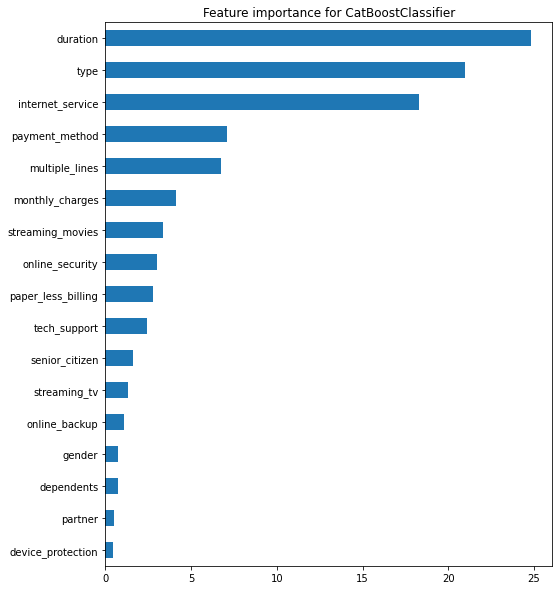

In [114]:
def print_fi_plot(fi,indexes,mod_name):
    coef = pd.Series(fi, index = indexes)
    imp_coef = coef.sort_values()
    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance for "+mod_name)
    plt.show()

print_fi_plot(model.feature_importances_, test[X].columns, 'CatBoostClassifier')

Видно, что часть факторов - слабозначимые для модели: пол, наличие партнёра, наличие иждивенцев, наличие услуги антивируса,  наличие облачного хранилища для создания резервных копий - не являются значимыми для выбранной модели и слабо влияют вероятность ухода клиента.

При удалении данных признаков из модели метрика вырастает до 
0.8686 с
0.8681


## Вывод

В ходе работы было выполнено:

- Загружены данные и проведена их предобработка.
- Обучено несколько моделей.
- Выполнено сравнение моделей.
- Выбрана лучшая модель по результатам метрики AUC-ROC.

Считаем оптимальной модель Catboost c  метриой AUC-ROC > 0.869.